In [1]:
import sys
import os
# setting path
sys.path.append('/work/scripts')
import pandas as pd
import seaborn as sns
from util import output as ou
import xarray as xr
from glob import glob
import numpy as np
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt

In [2]:
cell_y_coord = 0
cell_x_coord = 1

#BONA
#cell_y_coord = 3
#cell_x_coord = 0

In [3]:
depthlist = [0.05, 0.11, 0.2, 0.3]

def get_lwclayer_tlayer(depthlist, run_dir, var):
    
    ### read the netcdf output files and compute year from the time dimension
    data = xr.open_dataset(f'{run_dir}/output/{var}_monthly_tr.nc')
    data = data.to_dataframe()
    data.reset_index(inplace=True)
    data.dtypes
    data['time'] = data['time'].astype('|S80')
    data['time'] = data['time'].astype('|datetime64[ns]')
    data['month'] = data['time'].dt.month
    data['year'] = data['time'].dt.year
    data = data.sort_values(['time','x','y','layer'])


    ### read the netcdf output files on soil structure and compute year from the time dimension
    dz = xr.open_dataset(f'{run_dir}/output/LAYERDZ_monthly_tr.nc')
    dz = dz.to_dataframe()
    dz.reset_index(inplace=True)
    dz.dtypes
    dz['time'] = dz['time'].astype('|S80')
    dz['time'] = dz['time'].astype('|datetime64[ns]')
    dz['month'] = dz['time'].dt.month
    dz['year'] = dz['time'].dt.year
    dz = dz.sort_values(['time','x','y','layer'])

    ### read the netcdf output files on soil structure and compute year from the time dimension
    lt = xr.open_dataset(f'{run_dir}/output/LAYERTYPE_monthly_tr.nc')
    lt = lt.to_dataframe()
    lt.reset_index(inplace=True)
    lt.dtypes
    lt['time'] = lt['time'].astype('|S80')
    lt['time'] = lt['time'].astype('|datetime64[ns]')
    lt['month'] = lt['time'].dt.month
    lt['year'] = lt['time'].dt.year
    lt = lt.sort_values(['time','x','y','layer'])
    dz=pd.merge(dz, lt[['LAYERTYPE', 'time', 'x', 'y', 'layer']], on=['time','x','y','layer'])


    ### compute the depth of the bottom of every layers
    dz['z'] = dz.groupby(['time','x','y'])['LAYERDZ'].cumsum(axis=0)
    
    ### loop through the list of depths of reference to compute the soil variable at that depth via linear interpolation
    stdz = []
    for i in range(len(depthlist)):
        dpth = depthlist[i]
        print("depth:", dpth,"m")
        # extract the top and bottom layers the closest to the depth of reference
        dz['diff'] = dz['z']-float(dpth)
        top = dz.loc[dz[(dz['diff'] <= 0)].groupby(['time','x','y'])['diff'].idxmax()]
        bot = dz.loc[dz[(dz['diff'] >= 0)].groupby(['time','x','y'])['diff'].idxmin()]
        # select the variable value for each of these top and bottom layers
        datatop = pd.merge(data, top[['year','month', 'x','y','layer','LAYERDZ','LAYERTYPE','z']], how="left", on=['layer','year','month', 'x','y'])
        datatop = datatop[datatop['z'].notna()]
        datatop = datatop.rename(columns={"layer": "layertop", var: var+"top", "LAYERDZ": "dztop", "z": "ztop", "LAYERTYPE": "typetop"})
        databot = pd.merge(data, bot[['year', 'month', 'x','y','layer','LAYERDZ','LAYERTYPE','z']], how="left", on=['layer','year','month' , 'x','y'])
        databot = databot[databot['z'].notna()]
        databot = databot.rename(columns={"layer": "layerbot", var: var+"bot", "LAYERDZ": "dzbot", "z": "zbot", "LAYERTYPE": "typebot"})
        # merge the data to do the linear interpolation
        datastdz = pd.merge(datatop, databot, how="outer", on=['time','year', 'month', 'x','y'])
        datastdz['a'] = (datastdz[var+"top"] - datastdz[var+"bot"]) / (datastdz['ztop'] - datastdz['zbot'])
        datastdz['b'] = datastdz[var+"top"] - (datastdz['a'] * datastdz['ztop'])
        datastdz[var] = (datastdz['a'] * float(dpth)) + datastdz['b']
        datastdz['z'] = float(dpth)
        datastdz['layer'] = i
        datastdz['type'] = datastdz['typebot']
        datastdz = datastdz[['time','x','y','layer','z','type',var]]
        stdz.append(datastdz)

    stdz = pd.concat(stdz)
    
    return stdz

In [4]:
stdz = get_lwclayer_tlayer(depthlist, '/data/workflows/US-Prr_SWC_SA/sample_000000003/', 'LWCLAYER')

depth: 0.05 m
depth: 0.11 m
depth: 0.2 m
depth: 0.3 m


In [5]:
out_dir ='/data/workflows/US-Prr_SWC_SA/'

In [6]:
run_dirs = [d for d in glob(out_dir+'*/', recursive = True) if 'sample' in d]

In [7]:
run_dirs

['/data/workflows/US-Prr_SWC_SA/sample_000000038/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000040/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000015/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000003/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000004/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000048/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000041/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000019/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000011/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000039/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000032/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000034/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000042/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000035/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000001/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000022/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000026/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000049/',
 '/data/workflows/US-Prr_SWC_SA/sample_000000021/',
 '/data/work

In [8]:
lwc_layers = []
t_layers = []
sample_dfs=[]
for d in run_dirs:
    if 'GPP_monthly_tr.nc' in os.listdir(os.path.join(d, 'output')):
        sample = int(d.split('/')[-2].split('_')[-1])
        
        
        TLAYER = ou.load_trsc_dataframe(var ='TLAYER', timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}output/', only_tr=True)[0]
        LAYERDEPTH = ou.load_trsc_dataframe(var ='LAYERDEPTH', timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}output/', only_tr=True)[0]
        LAYERDZ = ou.load_trsc_dataframe(var ='LAYERDZ', timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}output/', only_tr=True)[0]
        GPP = ou.load_trsc_dataframe(var ='GPP', timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}output/', only_tr=True)[0][0]
        ALD = ou.load_trsc_dataframe(var ='ALD', timeres='yearly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}output/', only_tr=True)[0][0]
        RH = ou.load_trsc_dataframe(var ='RH', timeres='monthly', px_y=cell_y_coord, px_x=cell_x_coord, fileprefix=f'{d}output/', only_tr=True)[0][0]
        ALD.columns=['ALD']
        sample_df = pd.DataFrame({'date': GPP.index, 'sample': [sample]*len(GPP), #'LWCLAYER': LWCLAYER, 'TLAYER': TLAYER, 'LAYERDEPTH': LAYERDEPTH, 'LAYERDZ': LAYERDZ,
                                  'GPP': GPP, 'RH':RH})
        sample_df = pd.merge(sample_df, ALD, how='left', left_on='date', right_index=True)
        sample_dfs.append(sample_df)
        
        LWCLAYER = get_lwclayer_tlayer(depthlist, d, 'LWCLAYER')
        LWCLAYER['sample'] = sample
        lwc_layers.append(LWCLAYER)
        
        TLAYER = get_lwclayer_tlayer(depthlist, d, 'TLAYER')
        TLAYER['sample'] = sample
        t_layers.append(TLAYER)
        
sample_dfs=pd.concat(sample_dfs)
lwc_layers=pd.concat(lwc_layers)
t_layers=pd.concat(t_layers)

Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000038/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000038/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000038/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000038/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000038/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000038/output/RH_monthly_tr.nc
depth: 0.05 m
depth: 0.11 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.11 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000040/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000040/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000040/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000040/o

depth: 0.05 m
depth: 0.11 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.11 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000035/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000035/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000035/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000035/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000035/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000035/output/RH_monthly_tr.nc
depth: 0.05 m
depth: 0.11 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.11 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000001/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000001/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sam

depth: 0.05 m
depth: 0.11 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.11 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000013/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000013/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000013/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000013/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000013/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000013/output/RH_monthly_tr.nc
depth: 0.05 m
depth: 0.11 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.11 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000017/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000017/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sam

depth: 0.05 m
depth: 0.11 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.11 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000008/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000008/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000008/output/LAYERDZ_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000008/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000008/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000008/output/RH_monthly_tr.nc
depth: 0.05 m
depth: 0.11 m
depth: 0.2 m
depth: 0.3 m
depth: 0.05 m
depth: 0.11 m
depth: 0.2 m
depth: 0.3 m
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000025/output/TLAYER_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sample_000000025/output/LAYERDEPTH_monthly_tr.nc
Trying to open:  /data/workflows/US-Prr_SWC_SA/sam

In [9]:
t_layers.loc[t_layers['z']==0.11, 'z'] = 0.1
lwc_layers.loc[lwc_layers['z']==0.11, 'z'] = 0.1

In [10]:
path_to_met_data = '/data/comparison_data/US-Prr-monthly.csv'

In [11]:
met_data = pd.read_csv(path_to_met_data)
met_data['m_y'] = pd.to_datetime(met_data['m_y'])
met_data['year'] = met_data['m_y'].dt.year
met_data = met_data.replace(-9999.0, np.nan)
met_data['SWC_1_1_1'] = met_data['SWC_1_1_1']/100
met_data['SWC_1_2_1'] = met_data['SWC_1_2_1']/100
met_data['SWC_1_3_1'] = met_data['SWC_1_3_1']/100
met_data['SWC_1_4_1'] = met_data['SWC_1_4_1']/100
met_data.head()


,Unnamed: 0,Year_x,Month_x,GPP1 (gC/m2/d),RECO1 (gC/m2/d),NEE1 (gC/m2/d),GPP2 (gC/m2/d),RECO2 (gC/m2/d),NEE2 (gC/m2/d),Precip (mm),...,SWC_1_5_1,TS_1_1_1,TS_1_2_1,TS_1_3_1,TS_1_4_1,TS_1_5_1,TS_1_6_1,CO2,SW_IN,year
0,0,2010,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
1,1,2010,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
2,2,2010,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
3,3,2010,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
4,4,2010,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010


In [12]:
sample_dfs = sample_dfs.reset_index(drop=True)

In [13]:
sample_dfs

,date,sample,GPP,RH,0
0,1901-01-01,38,0.000000,61.014533,0.419758
1,1901-02-01,38,0.000000,46.314243,NaN
2,1901-03-01,38,0.000000,40.623446,NaN
3,1901-04-01,38,0.000000,38.841127,NaN
4,1901-05-01,38,108.667493,40.405585,NaN
...,...,...,...,...,...
72595,2021-08-01,23,245.839621,0.000607,NaN
72596,2021-09-01,23,138.004666,36.406956,NaN
72597,2021-10-01,23,1.829074,39.684945,NaN
72598,2021-11-01,23,0.000000,50.869399,NaN


In [14]:
lwc_layers

,time,x,y,layer,z,type,LWCLAYER,sample
0,1901-01-01,1,0,0,0.05,1.0,0.000000,38
1,1901-02-01,1,0,0,0.05,1.0,0.000000,38
2,1901-03-01,1,0,0,0.05,1.0,0.000000,38
3,1901-04-01,1,0,0,0.05,1.0,0.002028,38
4,1901-05-01,1,0,0,0.05,1.0,0.399598,38
...,...,...,...,...,...,...,...,...
1447,2021-08-01,1,0,3,0.30,2.0,0.291177,23
1448,2021-09-01,1,0,3,0.30,2.0,0.553816,23
1449,2021-10-01,1,0,3,0.30,2.0,0.589142,23
1450,2021-11-01,1,0,3,0.30,2.0,0.484058,23


In [15]:
lwc_layers[(lwc_layers['time'].dt.year>2010) & (lwc_layers['sample']==0)]

,time,x,y,layer,z,type,LWCLAYER,sample
1320,2011-01-01,1,0,0,0.05,1.0,0.000000,0
1321,2011-02-01,1,0,0,0.05,1.0,0.000000,0
1322,2011-03-01,1,0,0,0.05,1.0,0.000000,0
1323,2011-04-01,1,0,0,0.05,1.0,0.057504,0
1324,2011-05-01,1,0,0,0.05,1.0,0.226406,0
...,...,...,...,...,...,...,...,...
1447,2021-08-01,1,0,3,0.30,3.0,0.513599,0
1448,2021-09-01,1,0,3,0.30,3.0,0.513599,0
1449,2021-10-01,1,0,3,0.30,3.0,0.513599,0
1450,2021-11-01,1,0,3,0.30,3.0,0.513599,0


<AxesSubplot:xlabel='date', ylabel='GPP'>

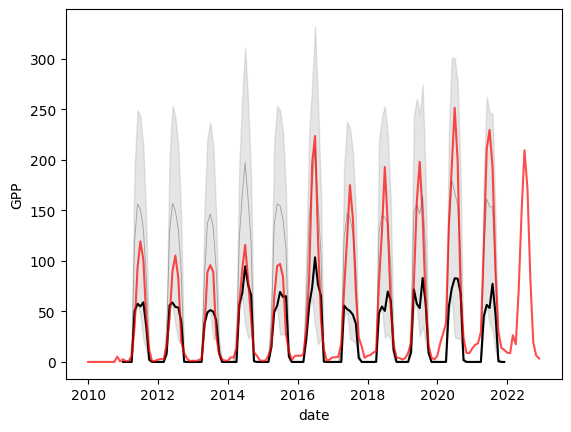

In [73]:
#9, 17, 18, 19, 23, 24, 37, 42
sns.lineplot(data=sample_dfs[sample_dfs['date'].dt.year>2010], x='date', y='GPP', color='grey', legend=False, alpha=0.7, errorbar = 'pi', linewidth=0.6)
sns.lineplot(data=sample_dfs[(sample_dfs['date'].dt.year>2010) & (sample_dfs['sample']==19)], x='date', y='GPP', color='black', legend=False)
sns.lineplot(data=met_data, x='m_y', y='GPP1 (gC/m2/d)', color='red', alpha=0.7)#
#sns.scatterplot(data=met_data, x='m_y', y='GPP2 (gC/m2/d)', color='blue', alpha=0.7, s=10)

In [17]:
met_data

,Unnamed: 0,Year_x,Month_x,GPP1 (gC/m2/d),RECO1 (gC/m2/d),NEE1 (gC/m2/d),GPP2 (gC/m2/d),RECO2 (gC/m2/d),NEE2 (gC/m2/d),Precip (mm),...,SWC_1_5_1,TS_1_1_1,TS_1_2_1,TS_1_3_1,TS_1_4_1,TS_1_5_1,TS_1_6_1,CO2,SW_IN,year
0,0,2010,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
1,1,2010,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
2,2,2010,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
3,3,2010,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
4,4,2010,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,151,2022,8,172.143095,175.243983,3.100888,347.097889,409.740752,62.642863,63.5,...,76.097014,4.043485,3.492134,3.395774,3.600310,2.758546,0.238595,432.237636,165.769305,2022
152,152,2022,9,81.015993,108.353769,27.337777,169.675557,264.044531,94.368974,39.0,...,76.405067,1.299983,1.528081,2.148819,2.756389,2.138210,0.151891,441.144164,86.208527,2022
153,153,2022,10,19.200998,40.810212,21.609214,37.596832,105.285708,67.688876,28.0,...,76.425855,0.193642,0.790048,1.795578,2.340833,1.778759,0.066593,441.635431,37.825830,2022
154,154,2022,11,6.136981,12.626030,6.489049,6.889540,29.696461,22.806921,14.0,...,75.965979,-0.046560,1.490735,2.519482,2.571293,1.892466,0.066099,437.010359,7.629517,2022


<AxesSubplot:xlabel='date', ylabel='RH'>

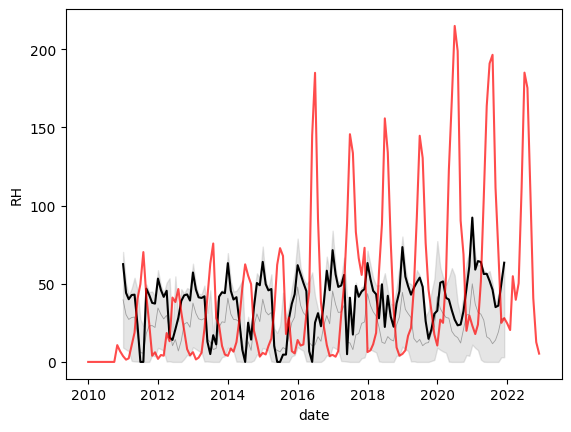

In [18]:
#9, 17, 18, 19, 23, 24, 37, 42
sns.lineplot(data=sample_dfs[sample_dfs['date'].dt.year>2010], x='date', y='RH', color='grey', legend=False, alpha=0.7, errorbar = 'pi', linewidth=0.6)
sns.lineplot(data=sample_dfs[(sample_dfs['date'].dt.year>2010) & (sample_dfs['sample']==16)], x='date', y='RH', color='black', legend=False)
sns.lineplot(data=met_data, x='m_y', y='RECO1 (gC/m2/d)', color='red', alpha=0.7)#
#sns.scatterplot(data=met_data, x='m_y', y='GPP2 (gC/m2/d)', color='blue', alpha=0.7, s=10)

In [19]:
t_layers=t_layers.reset_index(drop=True)
lwc_layers=lwc_layers.reset_index(drop=True)

In [20]:
tlayer_merged = t_layers[['time', 'z', 'TLAYER', 'sample']].merge(met_data[['m_y', 'TS_1_2_1', 'TS_1_3_1', 'TS_1_4_1']], left_on = ['time'], right_on=['m_y'], how='left')
tlayer_merged= tlayer_merged.loc[~tlayer_merged['TS_1_2_1'].isna() & ~tlayer_merged['TS_1_3_1'].isna() & ~tlayer_merged['TS_1_4_1'].isna() & ~tlayer_merged['TLAYER'].isna()]

In [21]:
lwclayer_merged = lwc_layers[['time', 'z', 'LWCLAYER', 'sample']].merge(met_data[['m_y', 'SWC_1_2_1', 'SWC_1_3_1']], left_on = ['time'], right_on=['m_y'], how='left')
lwclayer_merged= lwclayer_merged.loc[~lwclayer_merged['SWC_1_2_1'].isna() & ~lwclayer_merged['SWC_1_3_1'].isna() & ~lwclayer_merged['LWCLAYER'].isna()]

In [22]:
r2s_10cm = []
r2s_20cm = []
r2s_30cm = []
samples = []
for sample in tlayer_merged['sample'].unique():
    tlayer_sample = tlayer_merged.loc[tlayer_merged['sample']==sample]
    if len(tlayer_sample.loc[tlayer_sample['z']==0.1])>0:
        r2_10cm = r2_score(tlayer_sample.loc[tlayer_sample['z']==0.1, 'TS_1_2_1'], tlayer_sample.loc[tlayer_sample['z']==0.1, 'TLAYER'])
        r2_20cm = r2_score(tlayer_sample.loc[tlayer_sample['z']==0.2, 'TS_1_3_1'], tlayer_sample.loc[tlayer_sample['z']==0.2, 'TLAYER'])
        r2_30cm = r2_score(tlayer_sample.loc[tlayer_sample['z']==0.3, 'TS_1_4_1'], tlayer_sample.loc[tlayer_sample['z']==0.3, 'TLAYER'])

        samples.append(sample)
        r2s_10cm.append(r2_10cm)
        r2s_20cm.append(r2_20cm)
        r2s_30cm.append(r2_30cm)
    
df_tlayer = pd.DataFrame({'sample': samples, 'r2_10cm': r2s_10cm, 'r2_20cm': r2s_20cm, 'r2_30cm': r2s_30cm})

In [23]:
df_tlayer.sort_values(by='r2_20cm')

,sample,r2_10cm,r2_20cm,r2_30cm
21,18,-1.507903,-3.269121,-4.322007
35,29,-1.463244,-2.897541,-3.744119
28,9,-1.210464,-2.562380,-3.602451
9,39,-1.217136,-2.496262,-3.341017
34,12,-1.186153,-2.453850,-3.159320
47,14,-1.076120,-2.444751,-3.572836
11,34,-0.514185,-1.659757,-2.398973
22,2,-1.148610,-1.648273,-2.194479
27,17,-0.316460,-1.389776,-2.102749
36,47,-0.611010,-1.311746,-1.868750


In [24]:
t_layers.loc[(t_layers['z']==0.2) & (t_layers['time'].dt.year>2010) & (t_layers['sample']==0)]

,time,x,y,layer,z,type,TLAYER,sample
114576,2011-01-01,1,0,2,0.2,2.0,-0.138093,0
114577,2011-02-01,1,0,2,0.2,2.0,-0.165046,0
114578,2011-03-01,1,0,2,0.2,2.0,-0.132580,0
114579,2011-04-01,1,0,2,0.2,2.0,-0.021846,0
114580,2011-05-01,1,0,2,0.2,2.0,-0.005038,0
...,...,...,...,...,...,...,...,...
114703,2021-08-01,1,0,2,0.2,2.0,1.104319,0
114704,2021-09-01,1,0,2,0.2,2.0,0.449022,0
114705,2021-10-01,1,0,2,0.2,2.0,-0.100087,0
114706,2021-11-01,1,0,2,0.2,2.0,-0.194354,0


<AxesSubplot:xlabel='time', ylabel='TLAYER'>

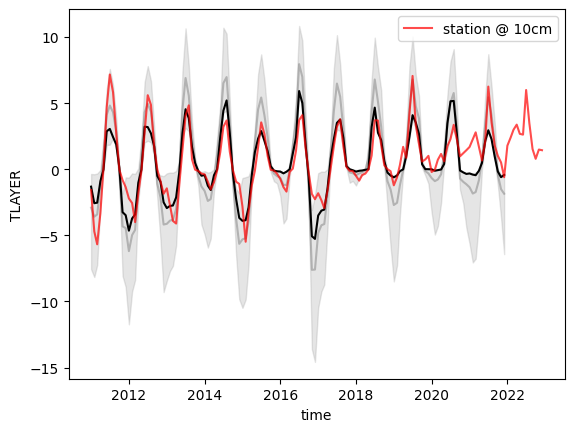

In [48]:
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.1) & (t_layers['time'].dt.year>2010)], x='time', y='TLAYER', color = 'grey', alpha=0.5, errorbar = 'pi')
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.1) & (t_layers['time'].dt.year>2010) & (t_layers['sample']==16)], x='time', y='TLAYER', color = 'black')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='TS_1_2_1', color='red', alpha = 0.7, label='station @ 10cm') #-0.1 m

<AxesSubplot:xlabel='time', ylabel='TLAYER'>

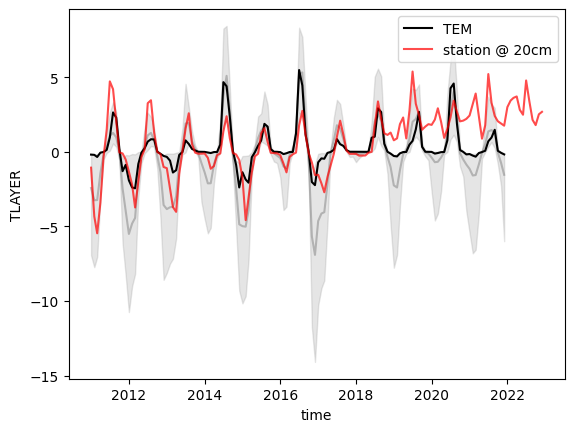

In [52]:
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.2) & (t_layers['time'].dt.year>2010)], x='time', y='TLAYER', color = 'grey', alpha=0.5, errorbar = 'pi')
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.2) & (t_layers['time'].dt.year>2010) & (t_layers['sample']==46)], x='time', y='TLAYER', color = 'black', label = 'TEM')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='TS_1_3_1', color='red', alpha = 0.7, label='station @ 20cm') #-0.1 m

<AxesSubplot:xlabel='time', ylabel='TLAYER'>

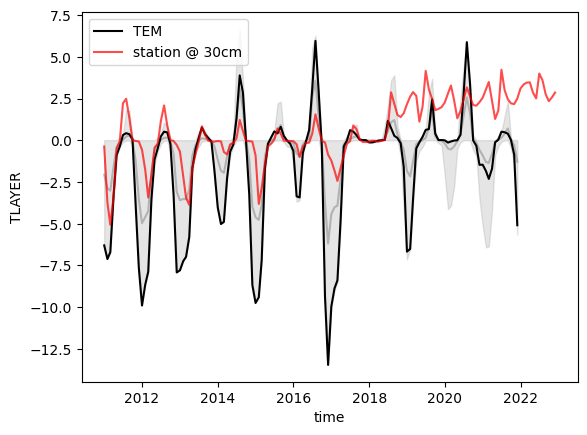

In [27]:
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.3) & (t_layers['time'].dt.year>2010)], x='time', y='TLAYER', color = 'grey', alpha=0.5, errorbar = 'pi')
sns.lineplot(data=t_layers.loc[(t_layers['z']==0.3) & (t_layers['time'].dt.year>2010) & (t_layers['sample']==39)], x='time', y='TLAYER', color = 'black', label = 'TEM')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='TS_1_4_1', color='red', alpha = 0.7, label='station @ 30cm') #-0.1 m

In [28]:
lwclayer_merged

,time,z,LWCLAYER,sample,m_y,SWC_1_2_1,SWC_1_3_1
1324,2011-05-01,0.05,0.199174,38,2011-05-01,0.390908,0.186683
1325,2011-06-01,0.05,0.226801,38,2011-06-01,0.814515,0.708910
1326,2011-07-01,0.05,0.293063,38,2011-07-01,0.809233,0.836910
1327,2011-08-01,0.05,0.277309,38,2011-08-01,0.831707,0.836910
1328,2011-09-01,0.05,0.259995,38,2011-09-01,0.836910,0.836910
...,...,...,...,...,...,...,...
290394,2021-07-01,0.30,0.058186,23,2021-07-01,0.655261,0.755904
290395,2021-08-01,0.30,0.291177,23,2021-08-01,0.751810,0.835364
290396,2021-09-01,0.30,0.553816,23,2021-09-01,0.839350,0.838763
290398,2021-11-01,0.30,0.484058,23,2021-11-01,0.561844,0.715605


In [29]:
lwclayer_r2s_10cm = []
lwclayer_r2s_20cm = []
samples = []
for sample in tlayer_merged['sample'].unique():
    lwclayer_sample = lwclayer_merged.loc[lwc_layers['sample']==sample]
    if len(lwclayer_sample.loc[lwclayer_sample['z']==0.1])>0:
        r2_10cm = r2_score(lwclayer_sample.loc[lwclayer_sample['z']==0.1, 'SWC_1_2_1'], lwclayer_sample.loc[lwclayer_sample['z']==0.1, 'LWCLAYER'])
        r2_20cm = r2_score(lwclayer_sample.loc[lwclayer_sample['z']==0.2, 'SWC_1_3_1'], lwclayer_sample.loc[lwclayer_sample['z']==0.2, 'LWCLAYER'])

        samples.append(sample)
        lwclayer_r2s_10cm.append(r2_10cm)
        lwclayer_r2s_20cm.append(r2_20cm)
    
df_lwclayer = pd.DataFrame({'sample': samples, 'r2_10cm': lwclayer_r2s_10cm, 'r2_20cm': lwclayer_r2s_20cm})

In [30]:
df_lwclayer.sort_values(by='r2_20cm')

,sample,r2_10cm,r2_20cm
4,4,-2.192470,-2.241734
18,21,-2.257143,-2.220280
2,15,-2.093577,-1.722994
10,32,-1.448445,-1.657993
12,42,-2.528659,-1.625520
19,0,-2.562533,-1.474438
41,10,-1.154736,-1.390072
11,34,-0.801456,-0.938429
35,29,-0.578138,-0.681685
21,18,-0.425792,-0.555457


<AxesSubplot:xlabel='time', ylabel='LWCLAYER'>

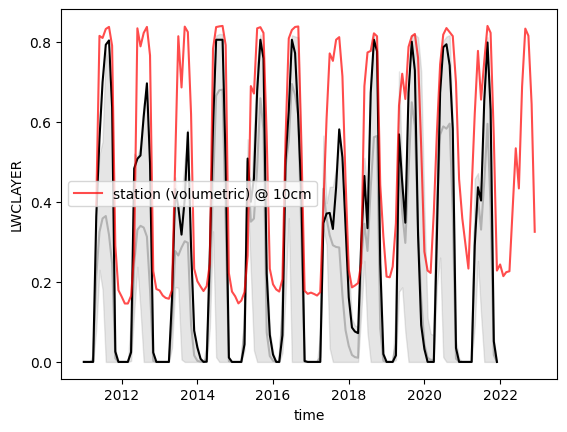

In [51]:
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.1) & (lwc_layers['time'].dt.year>2010)], x='time', y='LWCLAYER', color = 'grey', alpha = 0.5, errorbar = 'pi')
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.1) & (lwc_layers['time'].dt.year>2010) & (lwc_layers['sample']==46)], x='time', y='LWCLAYER', color = 'black')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='SWC_1_2_1', color = 'red', alpha = 0.7, label='station (volumetric) @ 10cm') #-0.1 m


<AxesSubplot:xlabel='time', ylabel='LWCLAYER'>

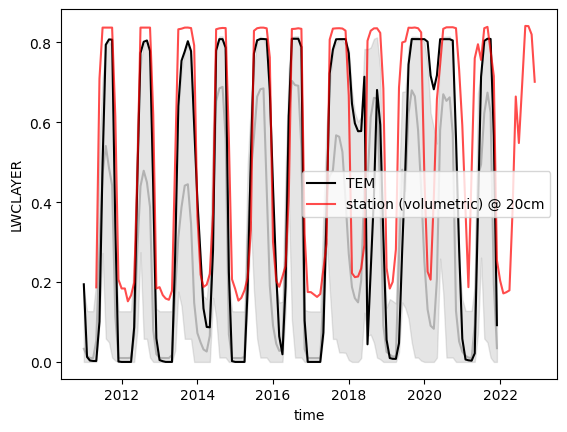

In [32]:
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.2) & (lwc_layers['time'].dt.year>2010)], x='time', y='LWCLAYER', color = 'grey', alpha = 0.5, errorbar = 'pi')
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.2) & (lwc_layers['time'].dt.year>2010) & (lwc_layers['sample']==27)], x='time', y='LWCLAYER', color = 'black', label='TEM')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='SWC_1_3_1', color = 'red', alpha = 0.7, label='station (volumetric) @ 20cm') #-0.1 m


<AxesSubplot:xlabel='time', ylabel='LWCLAYER'>

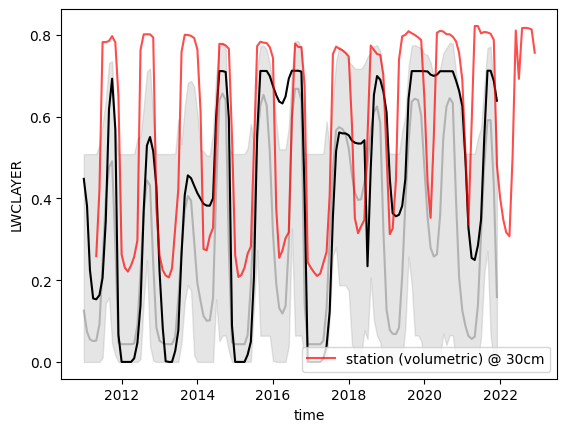

In [33]:
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.3) & (lwc_layers['time'].dt.year>2010)], x='time', y='LWCLAYER', color = 'grey', alpha = 0.5, errorbar = 'pi')
sns.lineplot(data=lwc_layers.loc[(lwc_layers['z']==0.3) & (lwc_layers['time'].dt.year>2010) & (lwc_layers['sample']==27)], x='time', y='LWCLAYER', color = 'black')
sns.lineplot(data = met_data.loc[met_data['year']>2010], x='m_y', y='SWC_1_4_1', color = 'red', alpha = 0.7, label='station (volumetric) @ 30cm') #-0.1 m

In [34]:
sample_matrix=pd.read_csv('/data/workflows/US-Prr_SWC_SA/sample_matrix.csv')

In [35]:
sample_matrix.iloc[30]

hksat(m)       0.134415
hksat(f)       0.155202
hksat(h)       0.000521
tcsolid(m)     0.270052
tcsolid(f)     0.127986
tcsolid(h)     0.128899
porosity(m)    0.978448
porosity(f)    0.816214
porosity(h)    0.719579
nfactor(s)     0.534681
nfactor(w)     0.370545
rhq10          1.614577
Name: 30, dtype: float64

In [36]:
#9, 22, 4,23 

In [37]:
sample_matrix.iloc[[9,22,4,23]].min()

hksat(m)       0.059102
hksat(f)       0.055882
hksat(h)       0.000443
tcsolid(m)     0.167111
tcsolid(f)     0.113247
tcsolid(h)     0.107486
porosity(m)    0.955023
porosity(f)    0.783759
porosity(h)    0.708849
nfactor(s)     0.517971
nfactor(w)     0.331659
rhq10          1.860264
dtype: float64

In [38]:
sample_matrix.iloc[[9,22,4,23]].max()

hksat(m)       0.130205
hksat(f)       0.110309
hksat(h)       0.001319
tcsolid(m)     0.292602
tcsolid(f)     0.159354
tcsolid(h)     0.202892
porosity(m)    0.972374
porosity(f)    0.816875
porosity(h)    0.786707
nfactor(s)     0.956620
nfactor(w)     0.924791
rhq10          2.034116
dtype: float64

In [39]:
sample_dfs['month'] = sample_dfs['date'].dt.month
t_layers['month'] = t_layers['time'].dt.month
lwc_layers['month'] = lwc_layers['time'].dt.month

In [40]:
sample_summary_s = sample_dfs.loc[(sample_dfs['month']>=6) & (sample_dfs['month']<10), ['sample', 'GPP', 'RH']].groupby(by='sample').mean()
t_layers_summary_s = t_layers.loc[(t_layers['month']>=6) & (t_layers['month']<10), ['sample', 'z', 'type', 'TLAYER']].groupby(by=['sample', 'z']).mean().reset_index()
lwc_layers_summary_s = lwc_layers.loc[(lwc_layers['month']>=6) & (lwc_layers['month']<10), ['sample', 'z', 'type', 'LWCLAYER']].groupby(by=['sample', 'z']).mean().reset_index()

In [41]:
sample_summary_w = sample_dfs.loc[(sample_dfs['month']<6) | (sample_dfs['month']>=10), ['sample', 'GPP', 'RH']].groupby(by='sample').mean()
t_layers_summary_w = t_layers.loc[(t_layers['month']<6) | (t_layers['month']>=10), ['sample', 'z', 'type', 'TLAYER']].groupby(by=['sample', 'z']).mean().reset_index()
lwc_layers_summary_w = lwc_layers.loc[(lwc_layers['month']<6) | (lwc_layers['month']>=10), ['sample', 'z', 'type', 'LWCLAYER']].groupby(by=['sample', 'z']).mean().reset_index()

In [42]:
sample_summary_s = sample_summary_s.merge(sample_matrix, left_index=True, right_index=True)
sample_summary_s = sample_summary_s.merge(t_layers_summary_s, left_index=True, right_on='sample', how='right')
sample_summary_s = sample_summary_s.merge(lwc_layers_summary_s, on=['sample', 'z'])

sample_summary_w = sample_summary_w.merge(sample_matrix, left_index=True, right_index=True)
sample_summary_w = sample_summary_w.merge(t_layers_summary_w, left_index=True, right_on='sample', how='right')
sample_summary_w = sample_summary_w.merge(lwc_layers_summary_w, on=['sample', 'z'])

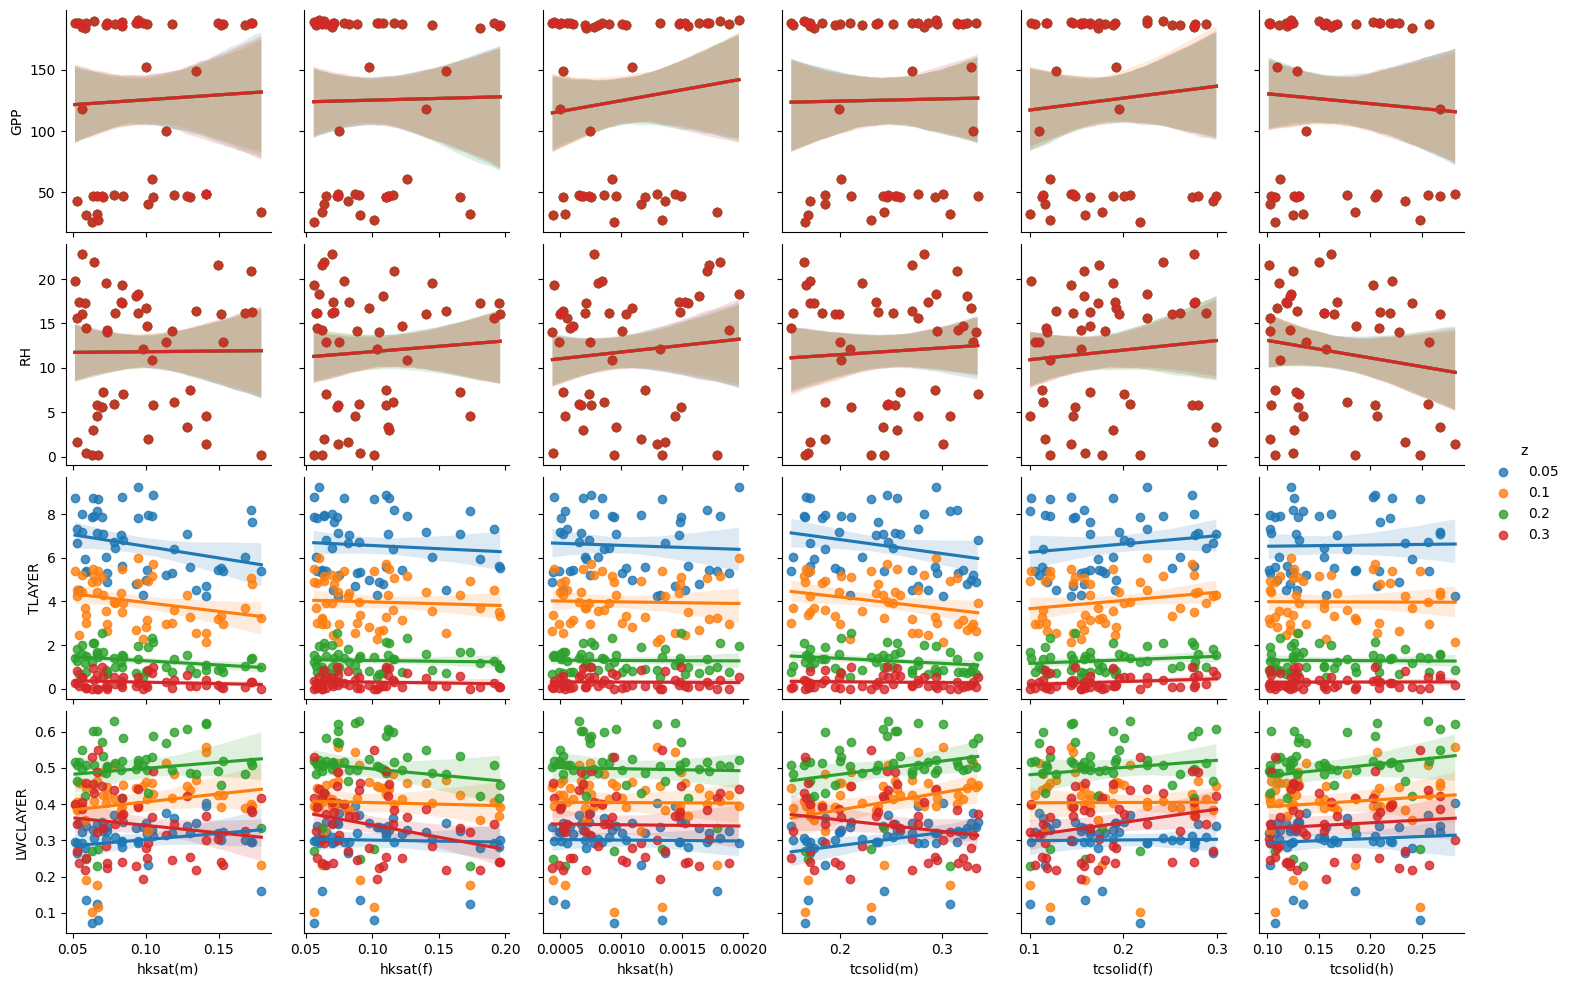

In [43]:
sns.pairplot(data=sample_summary_s, x_vars=['hksat(m)','hksat(f)','hksat(h)',
          'tcsolid(m)', 'tcsolid(f)', 'tcsolid(h)'], y_vars= ['GPP', 'RH', 'TLAYER', 'LWCLAYER'], hue='z', kind='reg')

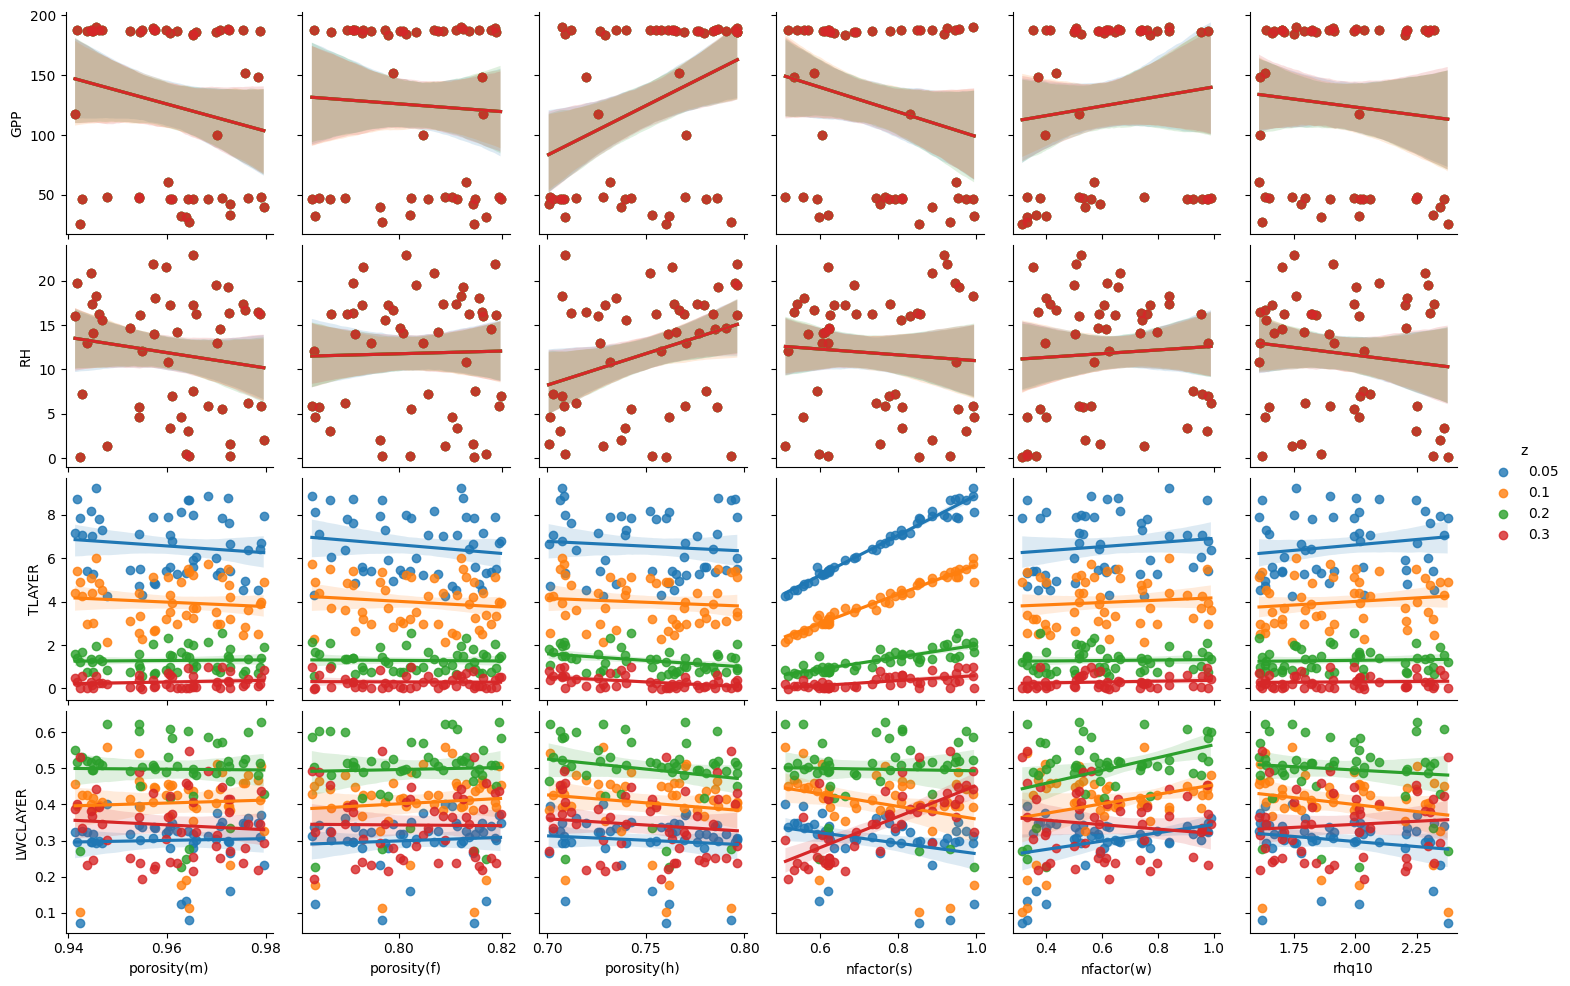

In [44]:
sns.pairplot(data=sample_summary_s, x_vars=['porosity(m)', 'porosity(f)', 'porosity(h)', 'nfactor(s)', 'nfactor(w)', 'rhq10'], 
             y_vars= ['GPP', 'RH', 'TLAYER', 'LWCLAYER'], hue='z', kind='reg')

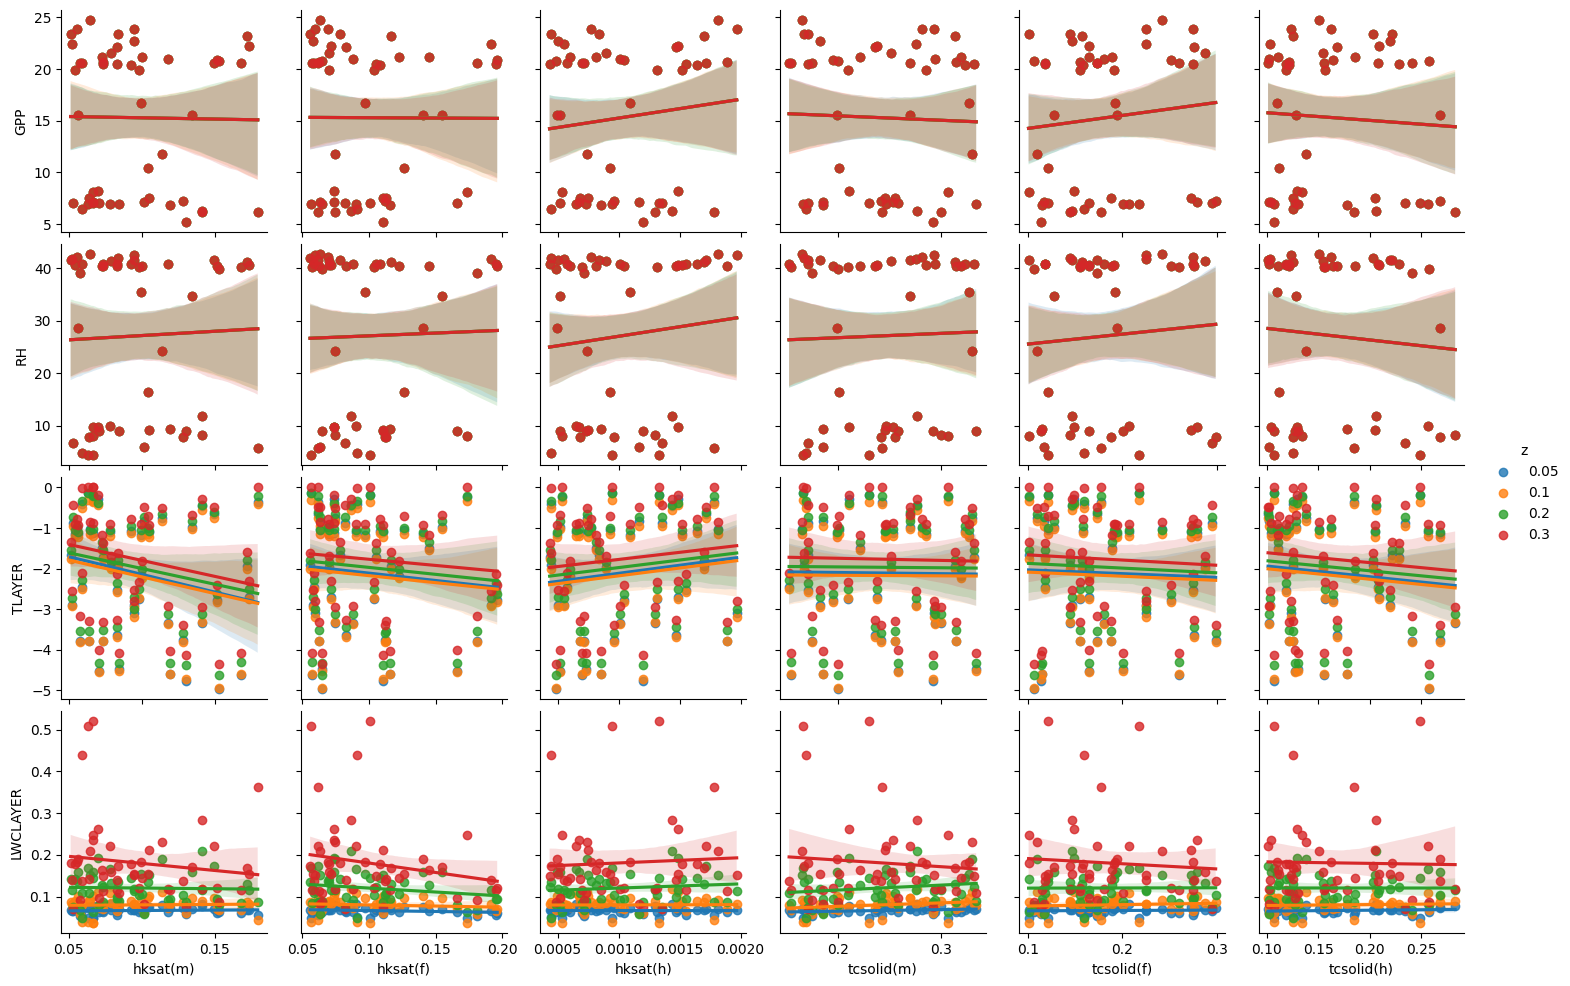

In [45]:
sns.pairplot(data=sample_summary_w, x_vars=['hksat(m)','hksat(f)','hksat(h)',
          'tcsolid(m)', 'tcsolid(f)', 'tcsolid(h)'], y_vars= ['GPP', 'RH', 'TLAYER', 'LWCLAYER'], hue='z', kind='reg')

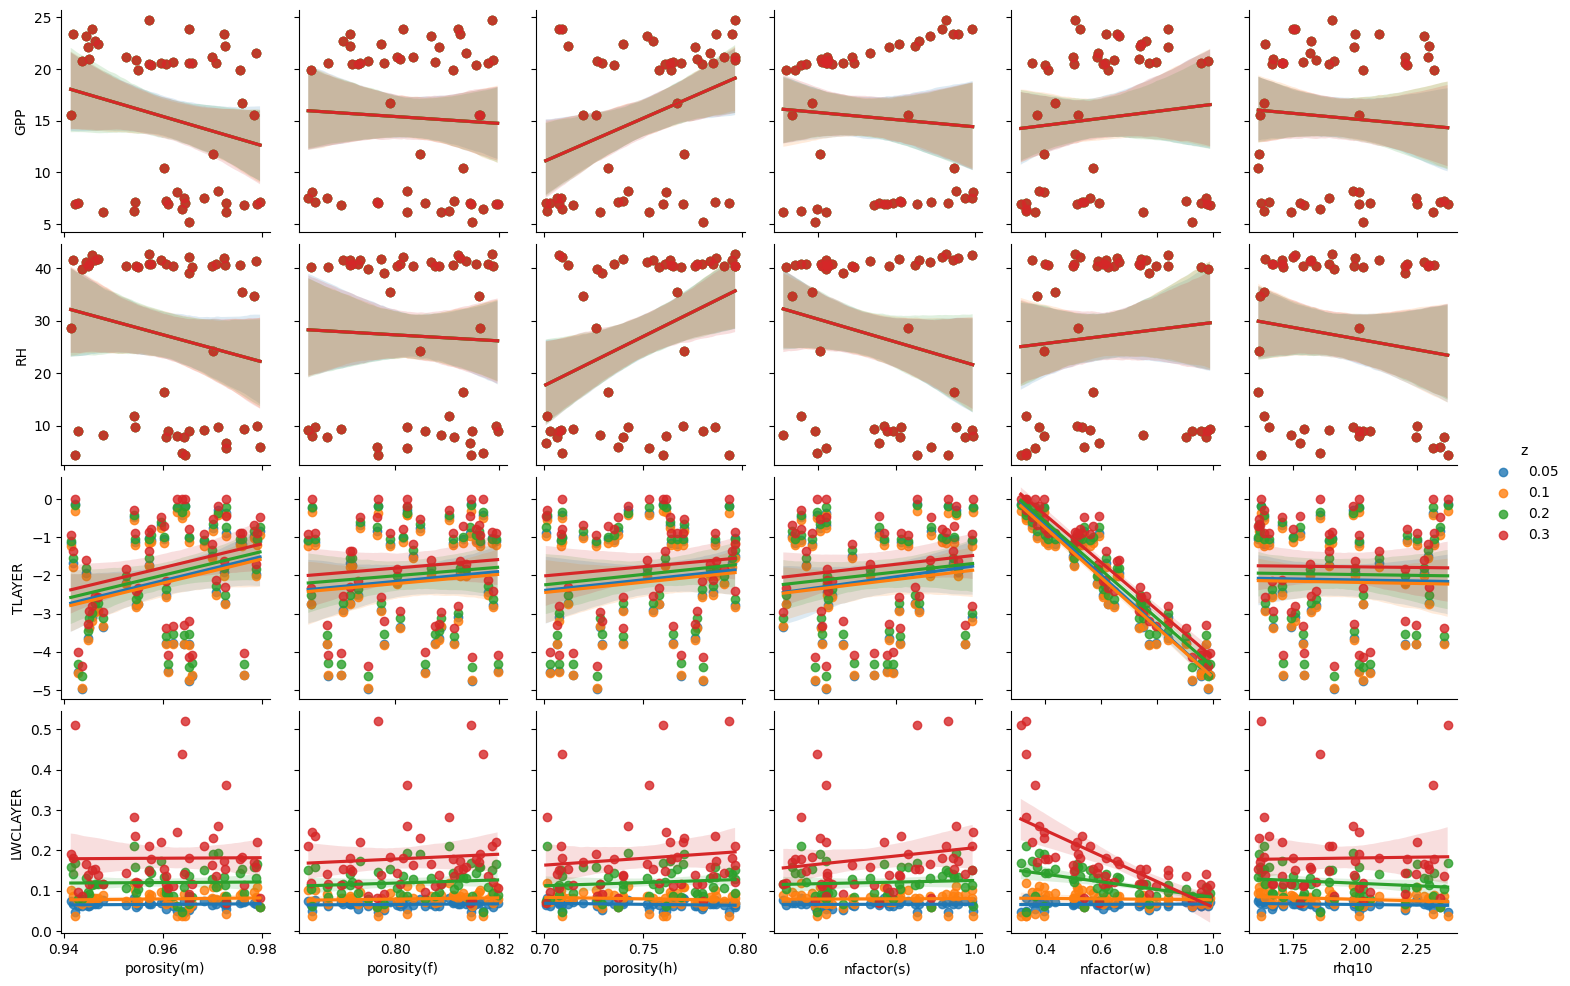

In [46]:
sns.pairplot(data=sample_summary_w, x_vars=['porosity(m)', 'porosity(f)', 'porosity(h)', 'nfactor(s)', 'nfactor(w)', 'rhq10'], 
             y_vars= ['GPP', 'RH', 'TLAYER', 'LWCLAYER'], hue='z', kind='reg')